This notebook takes a few ideas from a package developed from Xi Chen to help evaluate the placement of vertical levels, and to find discontinuous levels by inspection. This is an **interactive** notebook intended to be downloaded and played with, so you can modify the levels and then re-run to create the plots at the bottom. 

This requires the file `std_atmos_1976.py`, and also `fv_eta.F90` and `fv_eta.h` if you wish to use `set_eta()` from this notebook (instructions below).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
import os
from scipy import interpolate as sci_interp


In [2]:
large = 24; med = 20; small = 16
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 4),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'axes.titlepad': 6}
plt.rcParams.update(params)

The following cell (hidden by default) contains several sample ak/bk sets:

- ak_gfs, the GFS v15 63 level setup
- ak47, a well-designed 47-level setup for QBO simulation in HiRAM
- ak_bad, an example of a poor choice of levels with lots of discontinuities

The first two are examples of well-chosen level setups, which show acceptable values of the different level quantities. The third shows how well-meaning level setups can go wrong; this one has significant instability problems when implemented within a model.

You can edit the ak/bk and see below how new values change the results below. You can also add new sets of levels yourself.
See more levels at [https://gitlab.gfdl.noaa.gov/fv3team/atmos_cubed_sphere/-/blob/main/tools/fv_eta.h]

In [3]:
ak_bad = np.array([64.247,       221.958,     428.434,       \
       698.457,       1051.07995,  1510.71101,    \
      2108.36604,    2883.03811,   3883.05187,    \
      5167.14603,    6804.87379,   8875.64338,    \
     11264.35673,   12190.64366,   12905.42546,    \
     13430.87867,   13785.88765,   13986.77987,    \
     14047.96335,   13982.46770,   13802.40331,    \
     13519.33841,   13144.59486,   12689.45608,    \
     12165.28766,   11583.57006,   10955.84778,    \
     10293.60402,    9608.08306,    8910.07678,    \
      8209.70131,    7516.18560,    6837.69250,    \
      6181.19473,    5552.39653,    4955.72632,    \
      4394.37629,    3870.38682,    3384.76586,    \
      2937.63489, 2727.04570369,  2528.37666, 2336.65414612, 2155.78385, 1982.07937049,   \
      1818.20722, 1661.50963777,  1513.68173, 1372.87365583, 1240.03585, 1113.94503709,   \
       994.99144, 882.42791485,  776.23591, 676.02580495,  581.48797, 492.49223786,   \
       408.53400, 329.6675301,  255.26520, 185.5095999,  119.70243, 58.10797573, \
          0. ])

bk_bad = np.array([ 0.00000,       0.00000,       0.00000,    \
         0.00000,       0.00000,       0.00000,    \
         0.00000,       0.00000,       0.00000,    \
         0.00000,       0.00000,       0.00000,    \
         0.00201,       0.00792,       0.01755,    \
         0.03079,       0.04751,       0.06761,    \
         0.09097,       0.11746,       0.14690,    \
         0.17911,       0.21382,       0.25076,    \
         0.28960,       0.32994,       0.37140,    \
         0.41353,       0.45589,       0.49806,    \
         0.53961,       0.58015,       0.61935,    \
         0.65692,       0.69261,       0.72625,    \
         0.75773,       0.78698,       0.81398,    \
         0.83876,  0.85039942,     0.86138,   0.87194913,    0.88192, 0.89148058, \
         0.90050, 0.9091035,      0.91722,   0.92494359,    0.93223, 0.93913544, \
         0.94565,  0.95180932,     0.95762,  0.9631001,     0.96827, 0.97312748, \
         0.97771, 0.98201689,      0.98608,  0.98988262,     0.99347,  0.9968301, \
           1.  ])

ak_gfs = np.array([64.247,       137.790,       221.958,      \
              318.266,       428.434,       554.424,      \
              698.457,       863.05803,    1051.07995,    \
             1265.75194,    1510.71101,    1790.05098,    \
             2108.36604,    2470.78817,    2883.03811,    \
             3351.46002,    3883.05187,    4485.49315,    \
             5167.14603,    5937.04991,    6804.87379,    \
             7780.84698,    8875.64338,   10100.20534,    \
            11264.35673,   12190.64366,   12905.42546,    \
            13430.87867,   13785.88765,   13986.77987,    \
            14047.96335,   13982.46770,   13802.40331,    \
            13519.33841,   13144.59486,   12689.45608,    \
            12165.28766,   11583.57006,   10955.84778,    \
            10293.60402,    9608.08306,    8910.07678,    \
             8209.70131,    7516.18560,    6837.69250,    \
             6181.19473,    5552.39653,    4955.72632,    \
             4394.37629,    3870.38682,    3384.76586,    \
             2937.63489,    2528.37666,    2155.78385,    \
             1818.20722,    1513.68173,    1240.03585,    \
              994.99144,     776.23591,     581.48797,    \
              408.53400,     255.26520,     119.70243, 0. ])

bk_gfs = np.array([0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00201,       0.00792,       0.01755,    \
               0.03079,       0.04751,       0.06761,    \
               0.09097,       0.11746,       0.14690,    \
               0.17911,       0.21382,       0.25076,    \
               0.28960,       0.32994,       0.37140,    \
               0.41353,       0.45589,       0.49806,    \
               0.53961,       0.58015,       0.61935,    \
               0.65692,       0.69261,       0.72625,    \
               0.75773,       0.78698,       0.81398,    \
               0.83876,       0.86138,       0.88192,    \
               0.90050,       0.91722,       0.93223,    \
               0.94565,       0.95762,       0.96827,    \
               0.97771,       0.98608,       0.99347,  1.
])

ak47= np.array([   10.00000,      24.45365,      48.76776,  \
                  85.39458,     133.41983,     191.01402,  \
                 257.94919,     336.63306,     431.52741,  \
                 548.18995,     692.78825,     872.16512,  \
                1094.18467,    1368.11917,    1704.99489,  \
                2117.91945,    2622.42986,    3236.88281,  \
                3982.89623,    4885.84733,    5975.43260,  \
                7019.26669,    7796.15848,    8346.60209,  \
                8700.31838,    8878.27554,    8894.27179,  \
                8756.46404,    8469.60171,    8038.92687,  \
                7475.89006,    6803.68067,    6058.68992,  \
                5285.28859,    4526.01565,    3813.00206,  \
                3164.95553,    2589.26318,    2085.96929,  \
                1651.11596,    1278.81205,     962.38875,  \
                 695.07046,     470.40784,     282.61654,  \
                 126.92745,       0.00000,       0.00000   
])
bk47 = np.array([ 0.0000,        0.0000,        0.0000,      \
                0.00000,       0.00000,       0.00000,     \
                0.00000,       0.00000,       0.00000,     \
                0.00000,       0.00000,       0.00000,     \
                0.00000,       0.00000,       0.00000,     \
                0.00000,       0.00000,       0.00000,     \
                0.00000,       0.00000,       0.00000,     \
                0.00267,       0.01063,       0.02393,     \
                0.04282,       0.06771,       0.09917,     \
                0.13786,       0.18444,       0.23925,     \
                0.30193,       0.37100,       0.44379,     \
                0.51695,       0.58727,       0.65236,     \
                0.71094,       0.76262,       0.80757,     \
                0.84626,       0.87930,       0.90731,     \
                0.93094,       0.95077,       0.96733,     \
                0.98105,       0.99223,       1.00000      
])

There are a few user configuration parameters you can set up. These are surface elevations, whether to plot the vertical coordinate as a log coordinate, or which vertical coordinate to use: either pressure, height (z), or individual model levels (k).

In [4]:
#User-configurable parameters

zss = np.arange(0,5001.,2500.)

do_ylog = False
zcoord_type='p' #p,z,or k


In [5]:
def fv3_level_make_plots(ak,bk,levname,zss,do_ylog,zcoord_type):
    
    #Load standard atmosphere
    #Taken from /home/lmh/research/xic_levels

    data = np.loadtxt('std_atmos_1976.txt')
    zstd = data[:,0]
    Tstd = data[:,1]
    pstd = data[:,2]

    #Prepare interpolation between z and p
    Iz2p = sci_interp.interp1d(zstd,pstd,kind='linear')
    Ip2z = sci_interp.interp1d(pstd,zstd,kind='linear')

    fig,ax = plt.subplots(1,6,figsize=(24,11),sharey=True)

    for zs in zss:
        #Compute p and auxiliary quantities
        ps = Iz2p(zs)
        pe = ak + bk*ps
        delp =np.diff(pe)
        logpe = np.log(pe)
        dlogp = np.diff(logpe)
        pm = delp/dlogp

        ze = Ip2z(pe)
        dz = -np.diff(ze)
        zm = 0.5*(ze[:-1] + ze[1:])

        npz = pm.size
        ke = np.arange(npz+1) - 0.5
        km = np.arange(npz)

        zcoords_m = {'p':pm,'z':zm,'k':km}
        zcoords_e = {'p':pe,'z':ze,'k':ke}

        zcoord_labels = {'p':'Pressure [Pa]','z':'Height ASL [m]','k':'Coordinate Layer'}


        zcoord_m = zcoords_m[zcoord_type]
        zcoord_e = zcoords_e[zcoord_type]

        ax[0].plot(delp,zcoord_m,'.-',markersize=10)
        ax[0].set_title('delp [Pa]')
        if zcoord_type != 'k':
            dxax = np.diff(ax[0].get_xlim())[0]
            ax[0].text(delp[-1]+dxax*0.05,zcoord_m[-1],'p_s = %d hPa\nz_s = %d m' % (ps/100.,zs),
                   horizontalalignment='left',verticalalignment='center',)

        ax[1].plot(delp[:-1]/delp[1:],zcoord_e[1:-1],'.-',markersize=10)
        ax[1].set_title('ratio delp')


        ax[2].plot(dlogp,zcoord_m,'.-',markersize=10)
        ax[2].set_title('dlogp [Pa]')

        ax[3].plot(dlogp[:-1]/dlogp[1:],zcoord_e[1:-1],'.-',markersize=10)
        ax[3].set_title('ratio dlogp')


        ax[4].plot(dz,zcoord_m,'.-',markersize=10)
        ax[4].set_title('dz[m]')

        ax[5].plot(dz[:-1]/dz[1:],zcoord_e[1:-1],'.-',markersize=10)
        ax[5].set_title('ratio dz')

    if zcoord_type in  ('p','k'):
        ax[0].invert_yaxis()
    if do_ylog:
        ax[0].set_yscale('log')

    ax[0].set_ylabel(zcoord_labels[zcoord_type])

    #plt.suptitle('%s (%d): p_s = %d hPa, z_s = %d m' % (levname, npz, ps/100., zs));
    plt.suptitle('%s (%d)' % (levname, npz));    

This will make plots of different pressure/height increments on model levels with different surface elevations. The goal is to eliminate discontinuities or spikes in any of these fields, which can lead to numerical error or instability. Be sure to check the x-axes, which may differ greatly between variables and level setups.

For the three sample levels shown here (GFS, HiRAM QBO, and "Bad") you can see some interesting features:
- The GFS v15 levels are pretty well-made, with mostly smooth profiles. There is some evidence of their heritage in relatively coarse-resolution, hydrostatic spectral global models (this level setup dates to 2002 when the GFS ran with a 100 km nominal resolution): in particular there is a noticable (but small---check the x-axis again!) kink in the ratios at about 100 mb where the hybridization transitions to a pure-pressure coordinate, which is more noticable over high topography that wouldn't be resolved in a coarser model. 
- The HiRAM QBO levels uses a higher level to transition to a pure pressure coordinate, has a decidedly coarser spacing in the mid-troposphere (common in many climate models), and isn't quite as smooth as the GFS levels. The kinks in the coordinates are about of the same size as in the GFS L63.
- The "Bad" levels have some serious problems, as seen by the kinks several places in the profile and by the poor hybridization.

Note that this is for a **standard** atmosphere; pathological temperature structures may exist that can cause odd results.

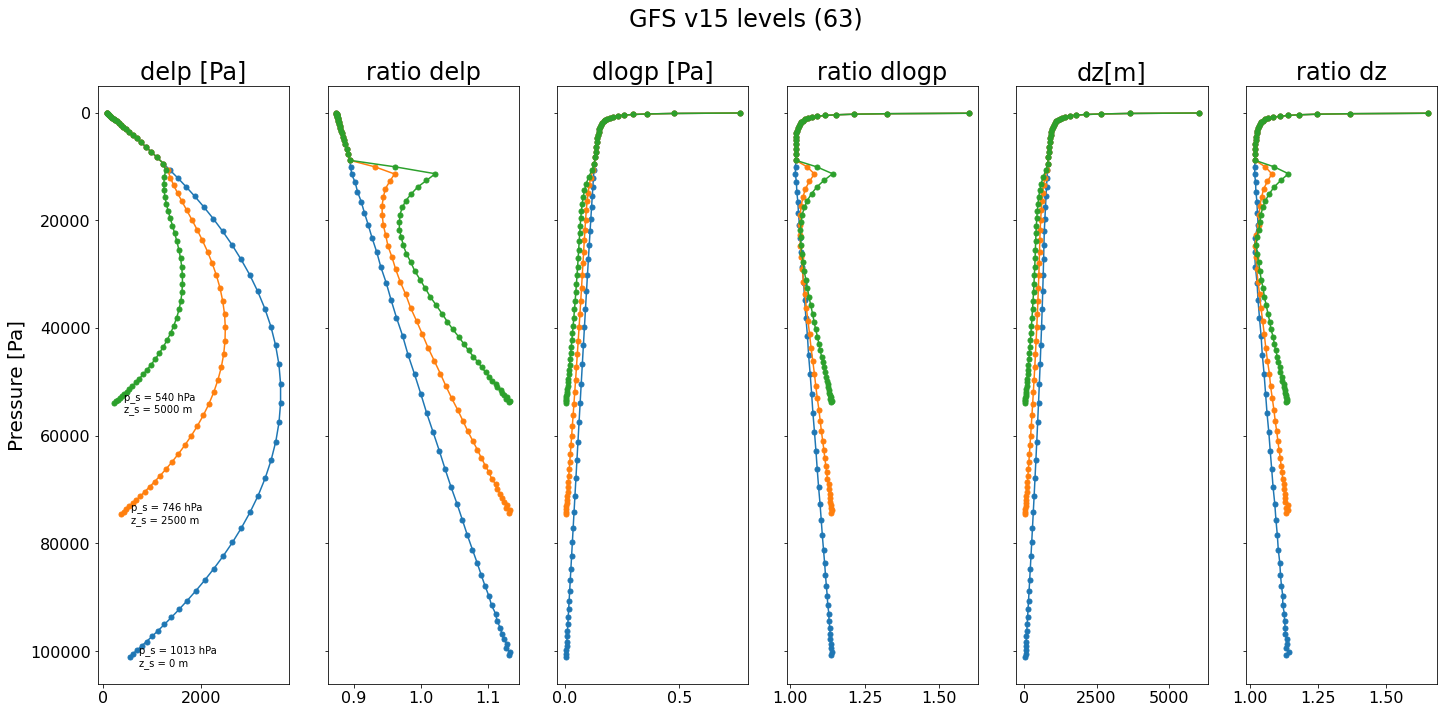

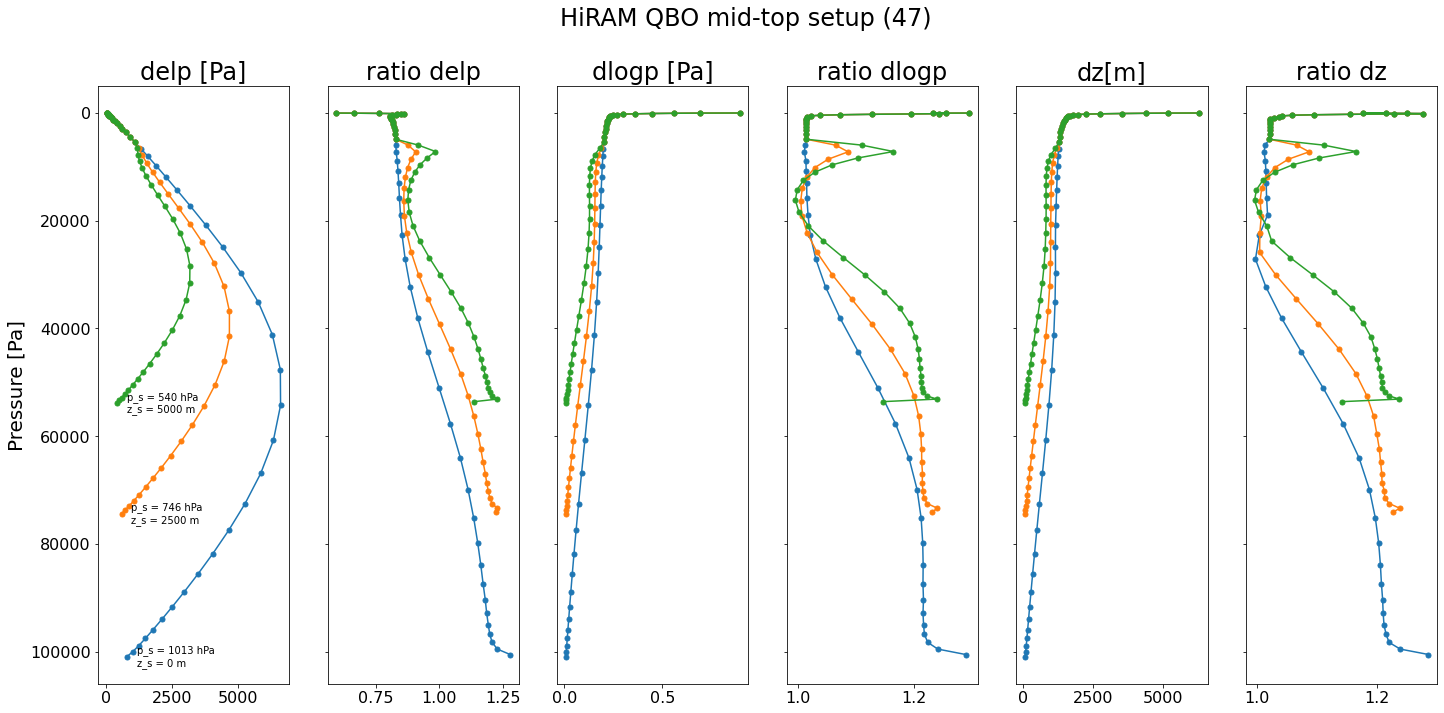

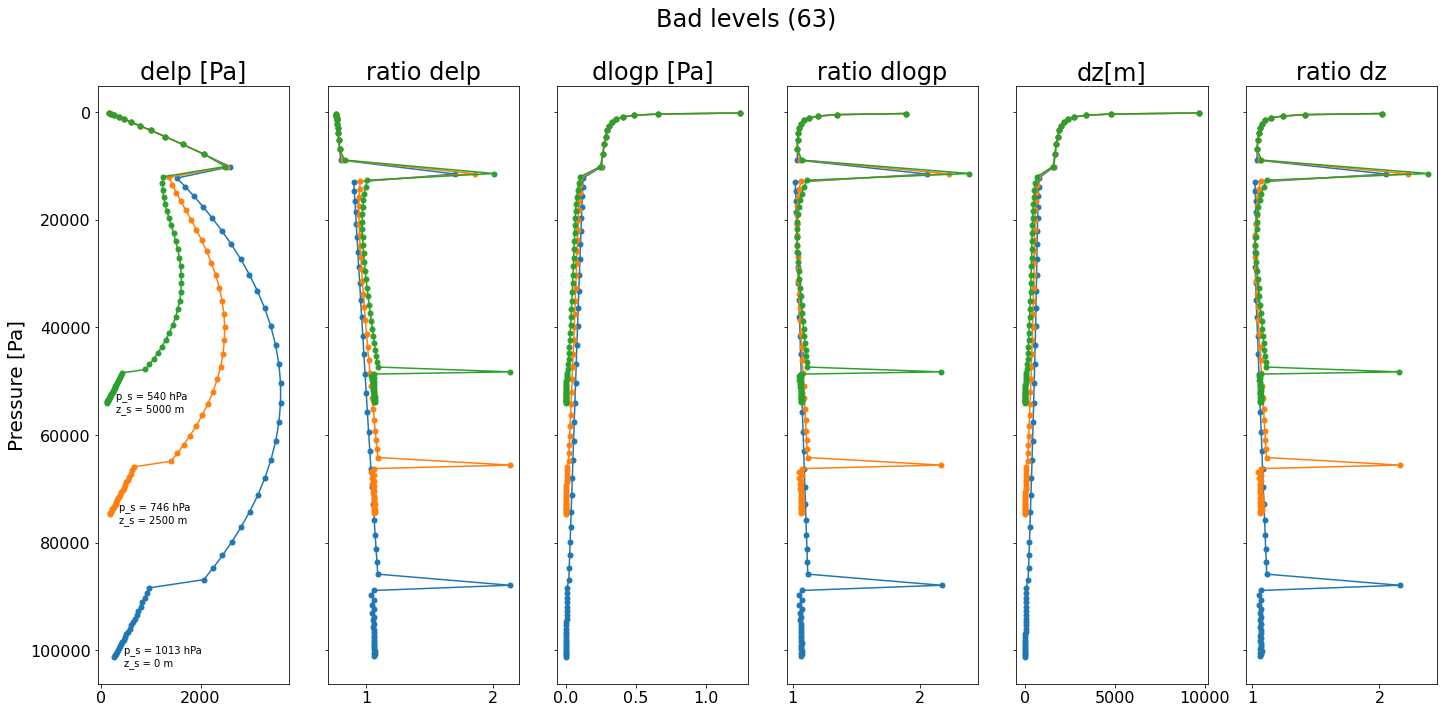

In [6]:
fv3_level_make_plots(ak_gfs,bk_gfs,"GFS v15 levels",zss,do_ylog,zcoord_type)
fv3_level_make_plots(ak47,bk47,"HiRAM QBO mid-top setup",zss,do_ylog,zcoord_type)
fv3_level_make_plots(ak_bad,bk_bad,"Bad levels",zss,do_ylog,zcoord_type)

If you have compiled the `fv_eta` wrapper (instructions given in `fv_eta.F90`, be sure to download `fv_eta.h` also), you can select any of the standard FV3 level setups. It is apparent different vertical level setups are chosen for different applications: in particular the kilometer-scale models (X-SHiELD and T-SHiELD) place many more levels in the boundary layer than the 13-km SHiELD, which more emphasizes consistency throughout the column.

Compilation instructions for the `fv_eta` wrapper:
- Requires an up-to-date version of `gcc` in your path, and f2py or f2py3.
- Download `fv_eta.F90` and `fv_eta.h` into the directory you are running this notebook from.

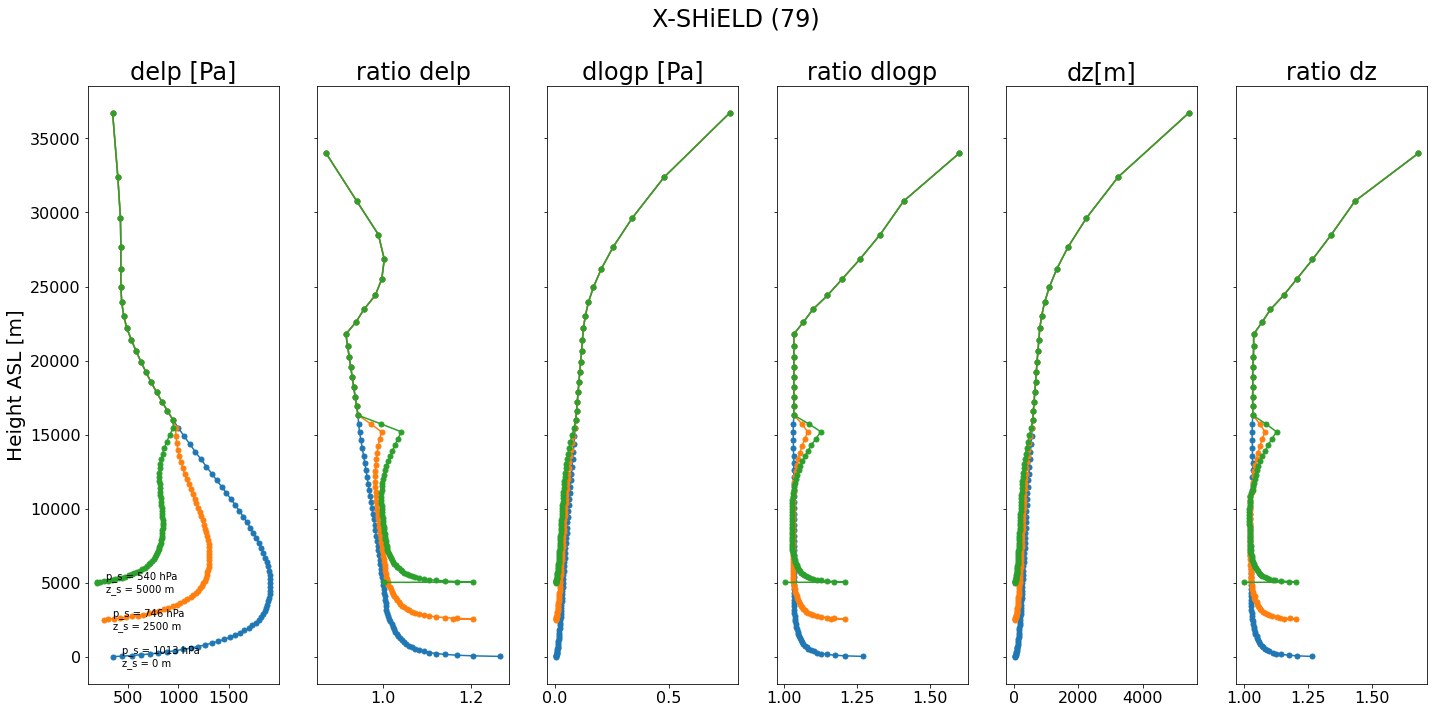

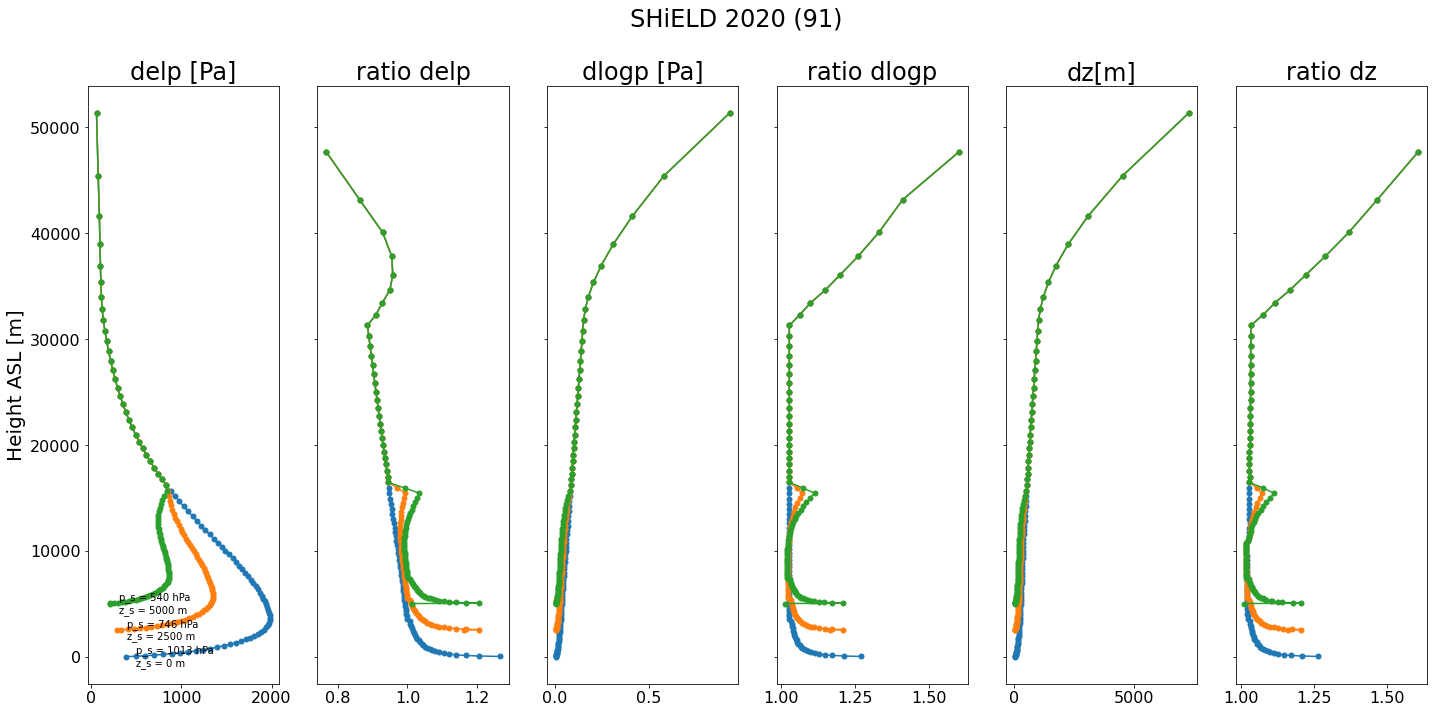

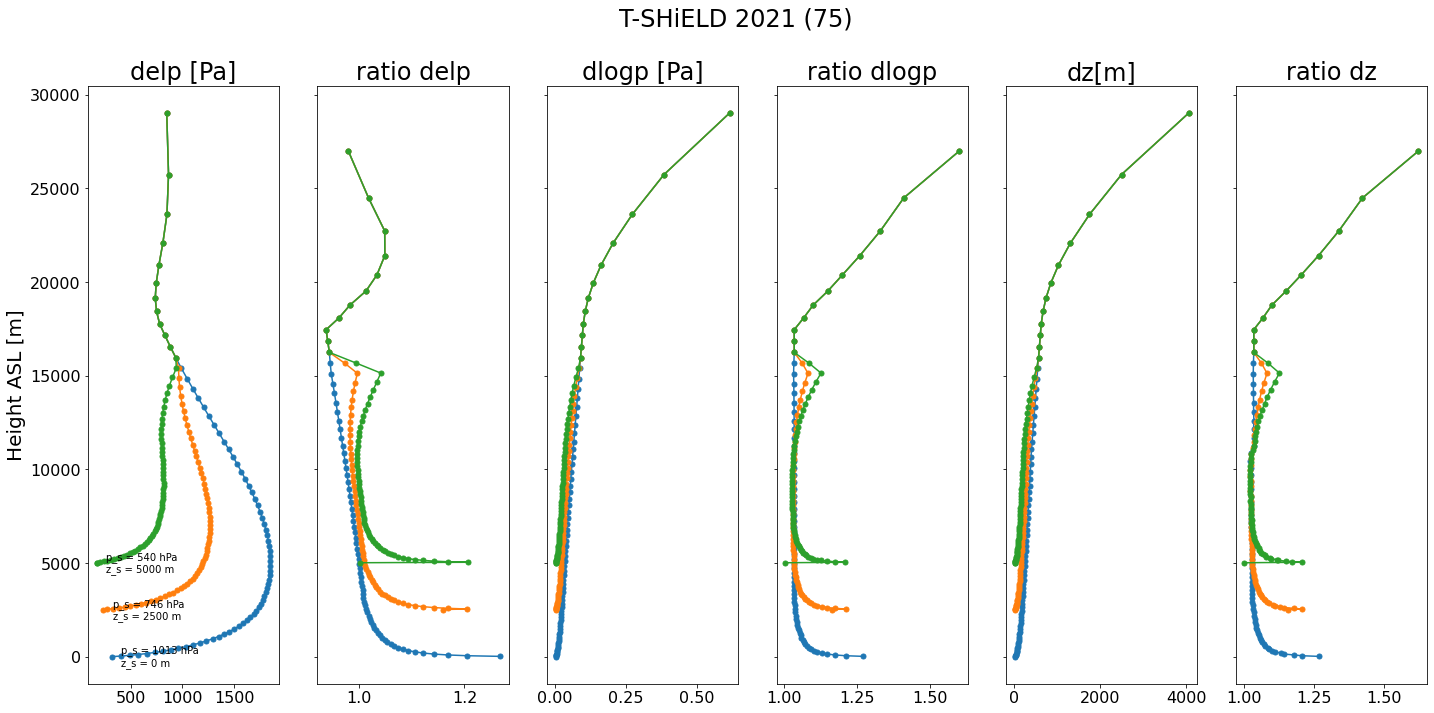

In [14]:
from fv_eta import fv_eta_mod as fv_eta
ak, bk = fv_eta.set_eta(79,'gcrm')
fv3_level_make_plots(ak,bk,"X-SHiELD",zss,do_ylog,'z')

ak, bk = fv_eta.set_eta(91,'')
fv3_level_make_plots(ak,bk,"SHiELD 2020",zss,do_ylog,'z')

ak, bk = fv_eta.set_eta(75,'')
fv3_level_make_plots(ak,bk,"T-SHiELD 2021",zss,do_ylog,'z')


Here are levels for two GFDL atmosphere models used for climate modeling. The 33-level AM4 setup is very similar to what GFDL has used back to AM2.1 (ca. 2003), the first FV-powered GFDL model, with the addition of a very thin first level (Shin et al., JAMES, 2018). 

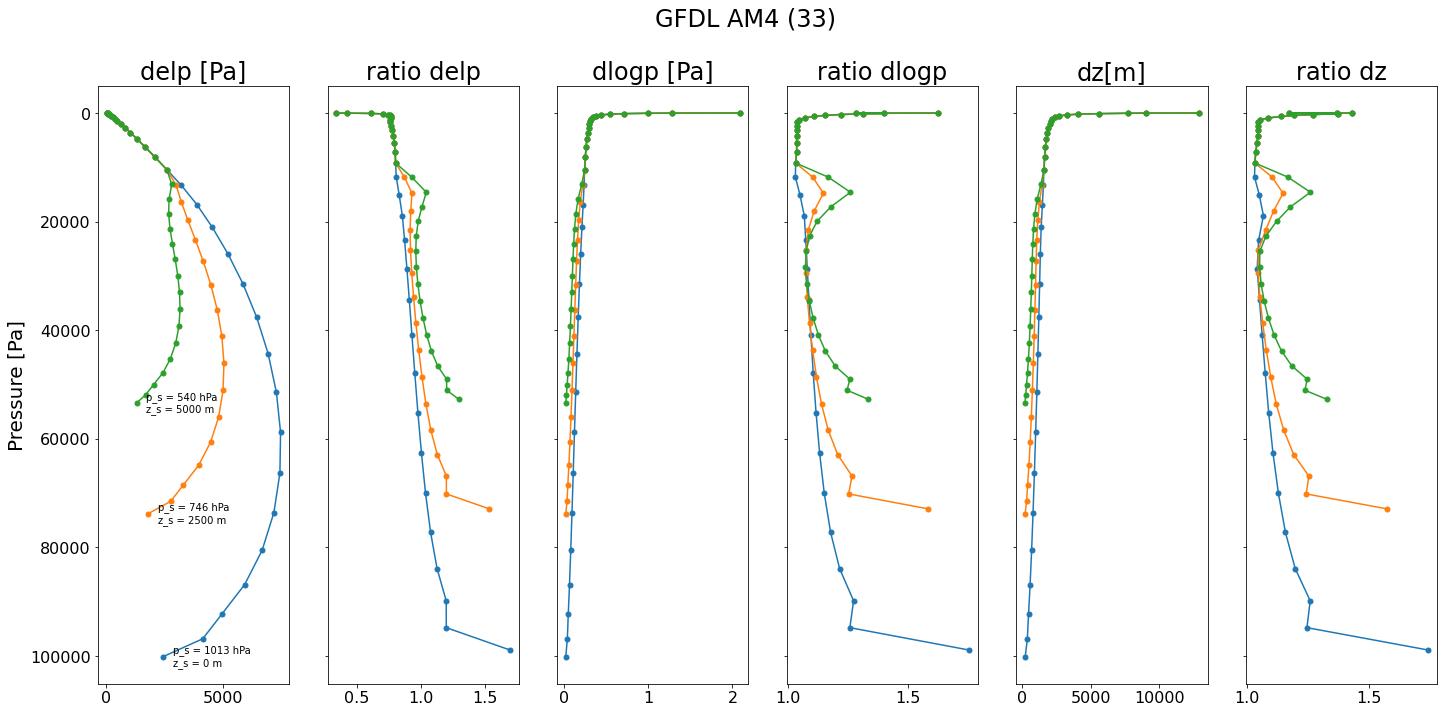

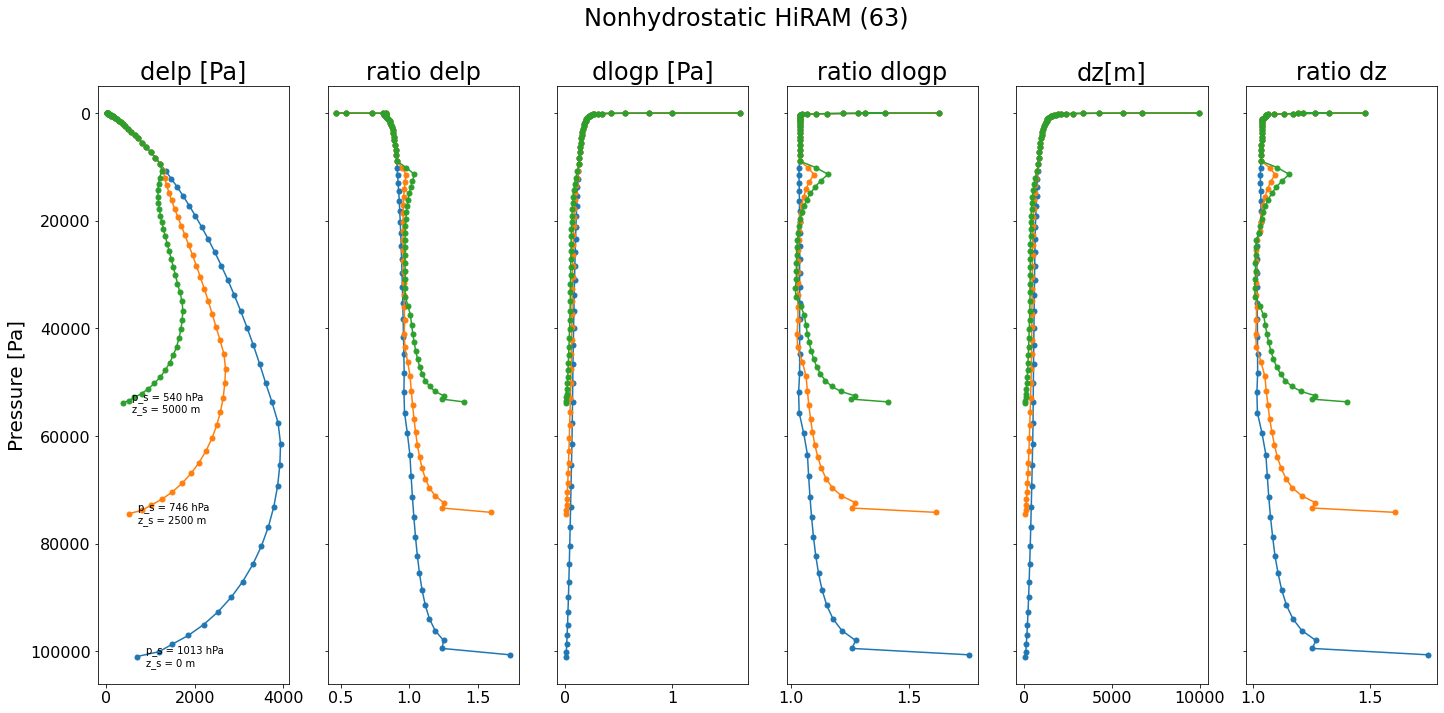

In [24]:
ak, bk = fv_eta.set_eta(33,'')
fv3_level_make_plots(ak,bk,"GFDL AM4",zss,do_ylog,'p')

ak, bk = fv_eta.set_eta(63,'hitop')
fv3_level_make_plots(ak,bk,"Nonhydrostatic HiRAM",zss,do_ylog,'p')

